In [70]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  classification_report, accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import shap
import joblib
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')


In [71]:
# 데이터 로더 
df = pd.read_csv('./data/netflix_users.csv')
print(df.head())

   User_ID            Name  Age Country Subscription_Type  Watch_Time_Hours  \
0        1  James Martinez   18  France           Premium             80.26   
1        2     John Miller   23     USA           Premium            321.75   
2        3      Emma Davis   60      UK             Basic             35.89   
3        4     Emma Miller   44     USA           Premium            261.56   
4        5      Jane Smith   68     USA          Standard            909.30   

  Favorite_Genre Last_Login  satisfaction_score  daily_watch_hours  \
0          Drama  2024.5.12                   7               2.68   
1         Sci-Fi   2025.2.5                   7              10.72   
2         Comedy  2025.1.24                   4               1.20   
3    Documentary  2024.3.25                   7               8.72   
4          Drama  2025.1.14                   8              30.31   

  primary_device  monthly_income  promo_offers_used  profile_count  \
0       Smart TV            4198  

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  25000 non-null  int64  
 1   Name                     25000 non-null  object 
 2   Age                      25000 non-null  int64  
 3   Country                  25000 non-null  object 
 4   Subscription_Type        25000 non-null  object 
 5   Watch_Time_Hours         25000 non-null  float64
 6   Favorite_Genre           25000 non-null  object 
 7   Last_Login               25000 non-null  object 
 8   satisfaction_score       25000 non-null  int64  
 9   daily_watch_hours        25000 non-null  float64
 10  primary_device           25000 non-null  object 
 11  monthly_income           25000 non-null  int64  
 12  promo_offers_used        25000 non-null  int64  
 13  profile_count            25000 non-null  int64  
 14  churn_status          

In [73]:
df.describe()

,User_ID,Age,Watch_Time_Hours,satisfaction_score,daily_watch_hours,monthly_income,promo_offers_used,profile_count
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,12500.500000,46.482880,500.468858,7.499800,16.682288,3618.189840,0.398400,2.64100
std,7217.022701,19.594861,286.381815,1.081132,9.546047,1483.751561,0.489578,1.23013
min,1.000000,13.000000,0.120000,3.000000,0.000000,-417.000000,0.000000,1.00000
25%,6250.750000,29.000000,256.567500,7.000000,8.550000,2436.000000,0.000000,2.00000
50%,12500.500000,46.000000,501.505000,8.000000,16.720000,3516.000000,0.000000,2.00000
75%,18750.250000,63.000000,745.732500,8.000000,24.860000,4663.000000,1.000000,3.00000
max,25000.000000,80.000000,999.990000,10.000000,33.330000,9696.000000,1.000000,5.00000


In [74]:
df.isnull().sum()

User_ID                    0
Name                       0
Age                        0
Country                    0
Subscription_Type          0
Watch_Time_Hours           0
Favorite_Genre             0
Last_Login                 0
satisfaction_score         0
daily_watch_hours          0
primary_device             0
monthly_income             0
promo_offers_used          0
profile_count              0
churn_status               0
preferred_watching_time    0
dtype: int64

In [75]:
df.drop(['User_ID', 'Name'], axis=1, inplace=True)

In [76]:
# 월평균 소득이 음수인 데이터 제거 
df[df['monthly_income'] < 0 ]
df.drop(df[df['monthly_income'] < 0 ].index, inplace=True)

In [77]:
# 현재시간을 기준으로 마지막 접속일수 계산 
df['Last_Login'] = pd.to_datetime(df['Last_Login'])
current_time = df['Last_Login'].max()
df['Last_Login_days'] = (current_time - df['Last_Login']).dt.days
df.drop(['Last_Login'], axis=1, inplace=True)


In [78]:
df.columns

Index(['Age', 'Country', 'Subscription_Type', 'Watch_Time_Hours',
       'Favorite_Genre', 'satisfaction_score', 'daily_watch_hours',
       'primary_device', 'monthly_income', 'promo_offers_used',
       'profile_count', 'churn_status', 'preferred_watching_time',
       'Last_Login_days'],
      dtype='object')

In [69]:
# #30일 이상으로 이탈자 변경 
# df['churn_status'] = df['Last_Login_days'].apply(lambda x: 1 if x >= 30 else 0)
# df['churn_status'].value_counts()

In [79]:
# object 타입 컬럼 범주화 
label_encoder = LabelEncoder()
columns = df.select_dtypes(include=['object']).columns
for column in columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()
# 라벨 인코더 저장 
joblib.dump(label_encoder, './model/label_encoder.pkl')
# 데이터 분리 
X = df.drop('churn_status', axis=1)
y = df['churn_status']
# 데이터 균형화 
X_sm, y_sm = SMOTE(random_state = 22).fit_resample(X, y)

In [11]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

In [12]:
X_train.shape, y_train.shape

((31100, 13), (31100,))

Model params 

In [13]:
models_and_params = [
    {
        'name': 'LogisticRegression',
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.01, 0.1, 1],  # 과도한 C는 복잡한 모델 → 낮게 시작
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    {
        'name': 'RandomForest',
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [100, 200],         
            'max_depth': [5, 10],              
            'min_samples_split': [5, 10],       
            'min_samples_leaf': [2, 4],        
            'max_features': ['sqrt']          
        }
    },
    {
        'name': 'XGBoost',
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        'params': {
            'n_estimators': [100],
            'learning_rate': [0.01, 0.1],       

            'subsample': [0.7, 0.8],            
            'colsample_bytree': [0.7, 0.8],     
            'reg_alpha': [0, 0.1],              # L1 정규화
            'reg_lambda': [1, 2]                # L2 정규화
        }
    },
    {
        'name': 'LightGBM',
        'model': LGBMClassifier(),
        'params': {
            'num_leaves': [15, 31],            
            'learning_rate': [0.01, 0.05],      
            'n_estimators': [100],
            'feature_fraction': [0.7, 0.8],     # 컬럼 샘플링
            'bagging_fraction': [0.7, 0.8],     # 데이터 샘플링
            'bagging_freq': [5],                # 샘플링 빈도
            'lambda_l1': [0, 0.1],              # L1 정규화
            'lambda_l2': [0, 0.1]               # L2 정규화
        }
    }
]


results = []

In [14]:
feature_names = X.columns.tolist()
feature_names

['Age',
 'Country',
 'Subscription_Type',
 'Watch_Time_Hours',
 'Favorite_Genre',
 'satisfaction_score',
 'daily_watch_hours',
 'primary_device',
 'monthly_income',
 'promo_offers_used',
 'profile_count',
 'preferred_watching_time',
 'Last_Login_days']


 GridSearch: LogisticRegression

 Classification Report for LogisticRegression:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      3874
           1       0.76      0.78      0.77      3902

    accuracy                           0.77      7776
   macro avg       0.77      0.77      0.77      7776
weighted avg       0.77      0.77      0.77      7776



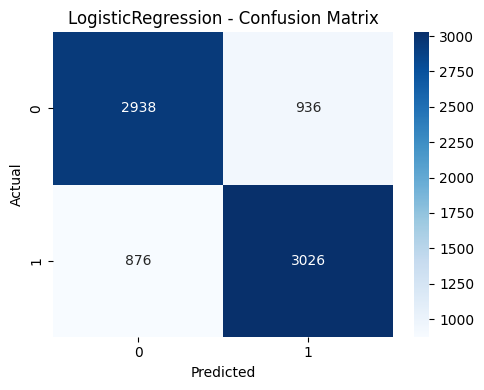

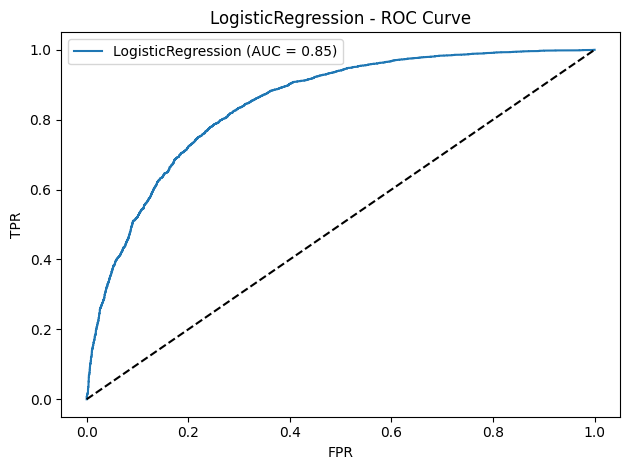

 모델 저장 완료: LogisticRegression_best_model.pkl

 GridSearch: RandomForest

 Classification Report for RandomForest:
              precision    recall  f1-score   support

           0       0.80      0.77      0.79      3874
           1       0.78      0.81      0.80      3902

    accuracy                           0.79      7776
   macro avg       0.79      0.79      0.79      7776
weighted avg       0.79      0.79      0.79      7776



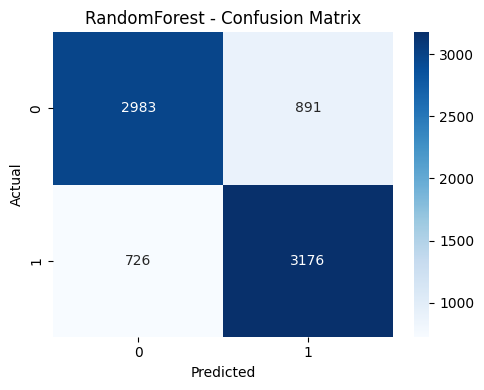

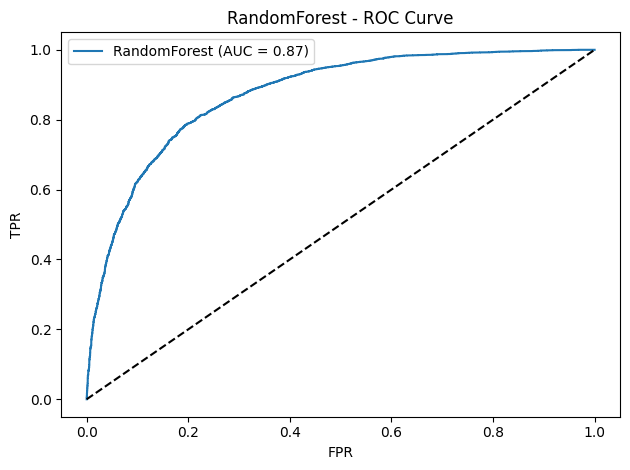

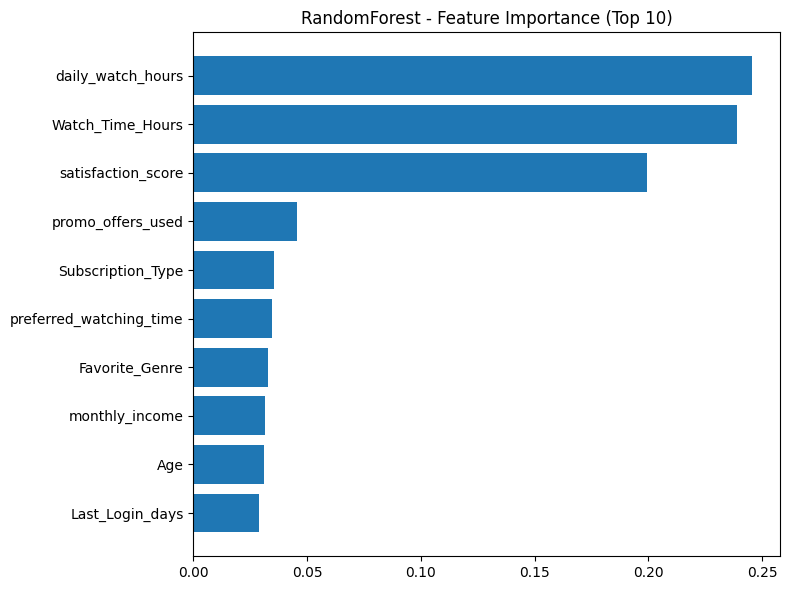

100%|===================| 15526/15552 [08:04<00:00]        

<Figure size 640x480 with 0 Axes>

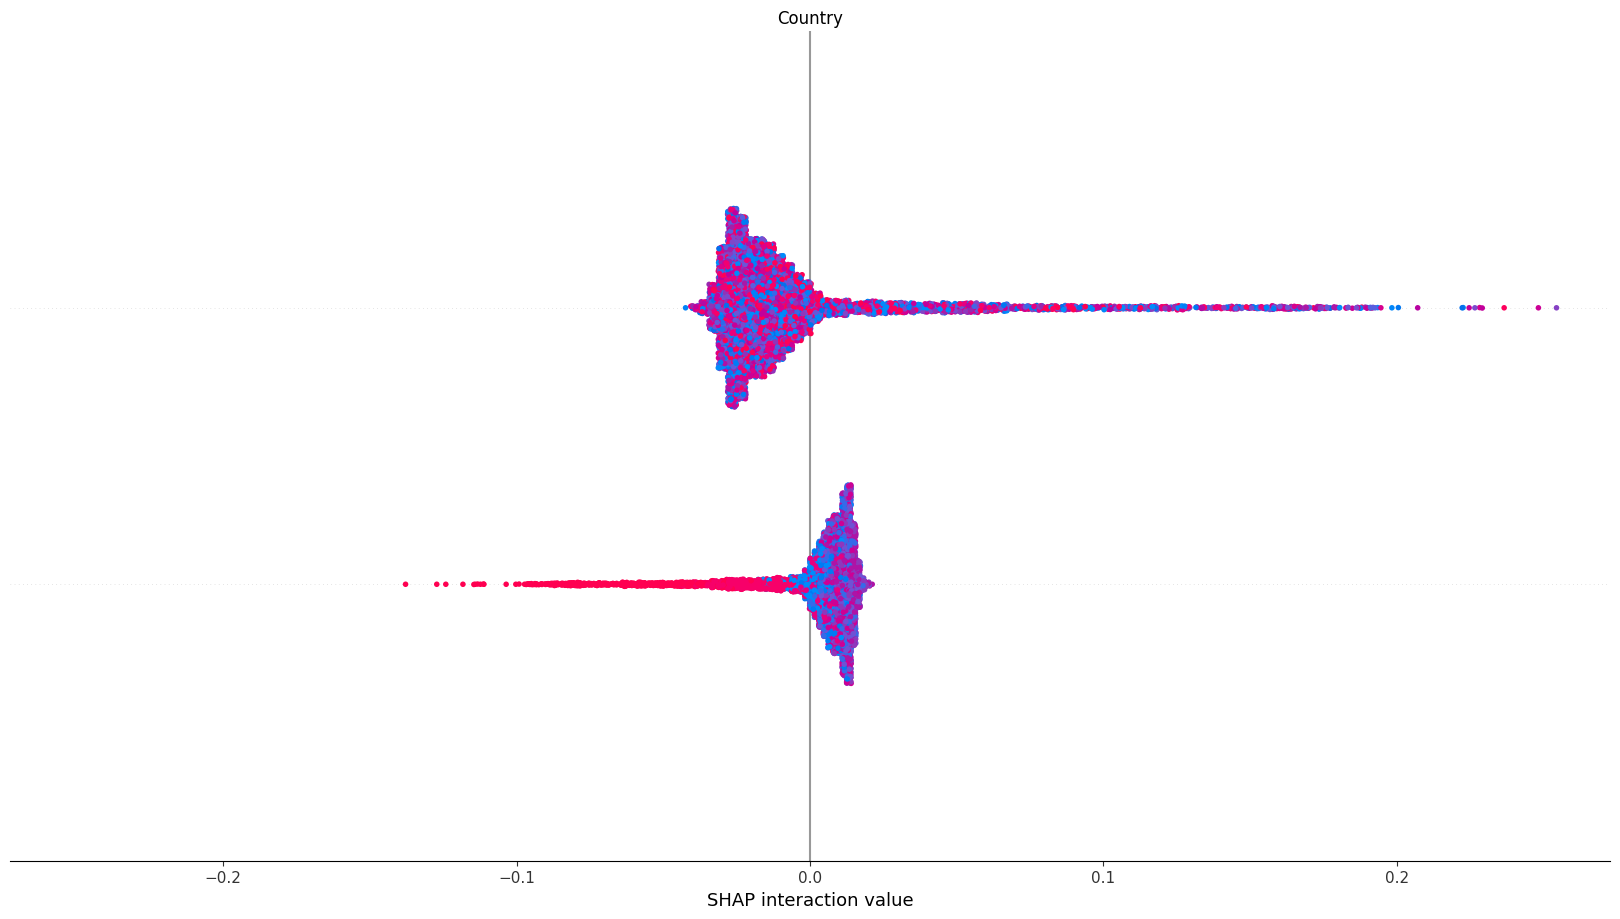

 모델 저장 완료: RandomForest_best_model.pkl

 GridSearch: XGBoost


/opt/anaconda3/envs/Netflix/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/Netflix/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/Netflix/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/Netflix/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [00:00:47] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encode


 Classification Report for XGBoost:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      3874
           1       0.80      0.81      0.80      3902

    accuracy                           0.80      7776
   macro avg       0.80      0.80      0.80      7776
weighted avg       0.80      0.80      0.80      7776



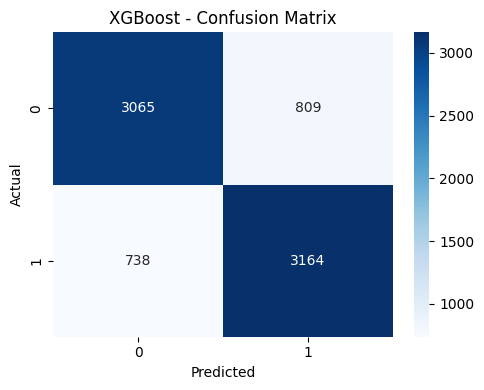

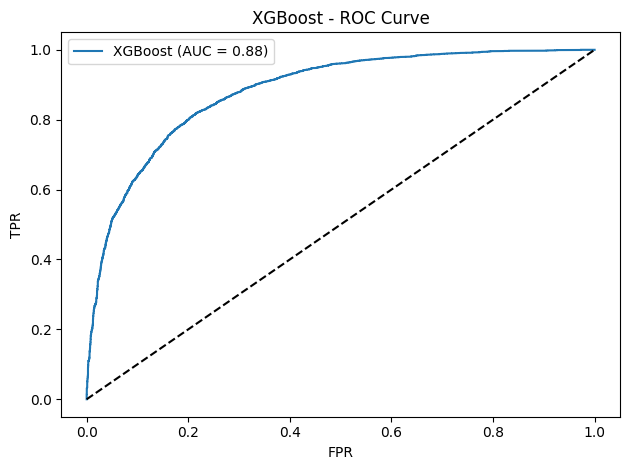

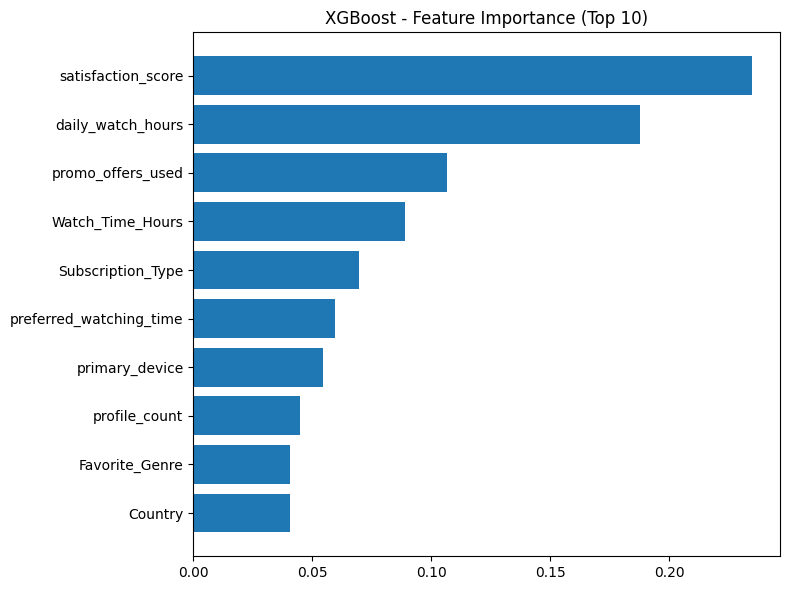

 99%|===================| 7684/7776 [00:29<00:00]        

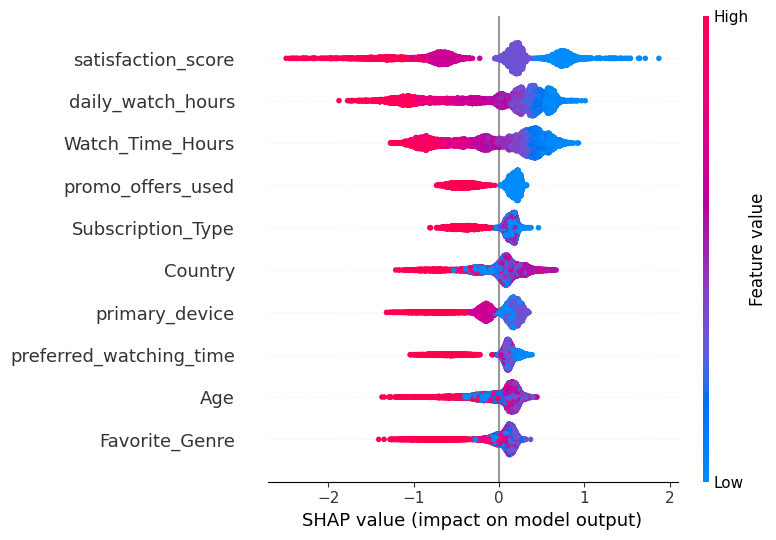

 모델 저장 완료: XGBoost_best_model.pkl

 GridSearch: LightGBM
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 

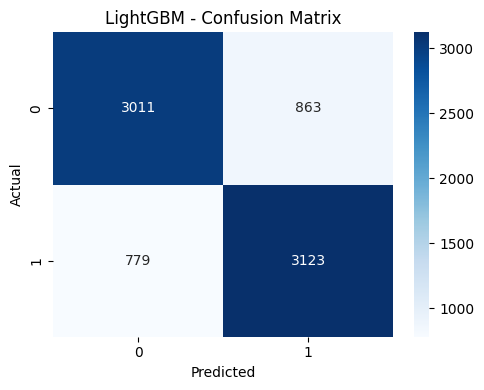

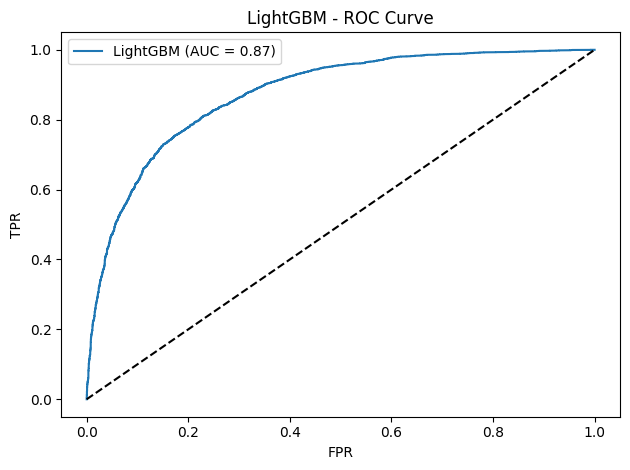

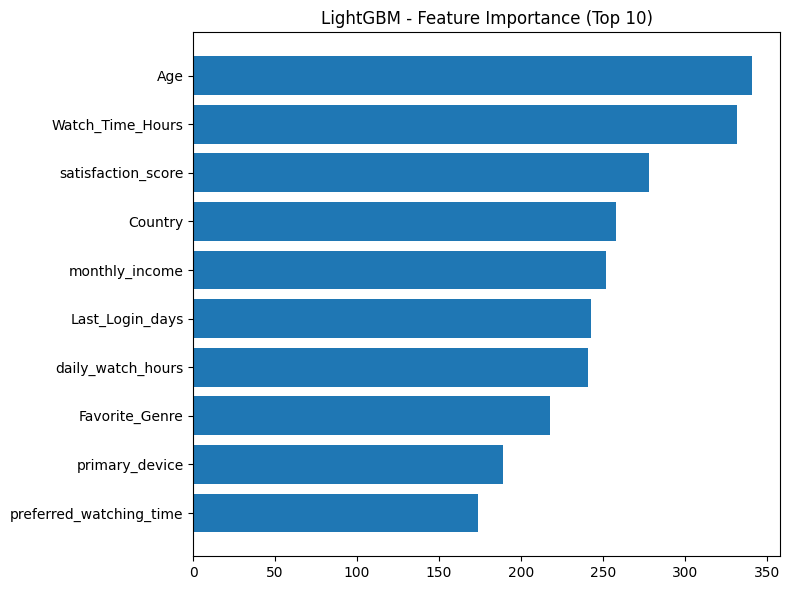

 97%|=================== | 7534/7776 [00:29<00:00]       

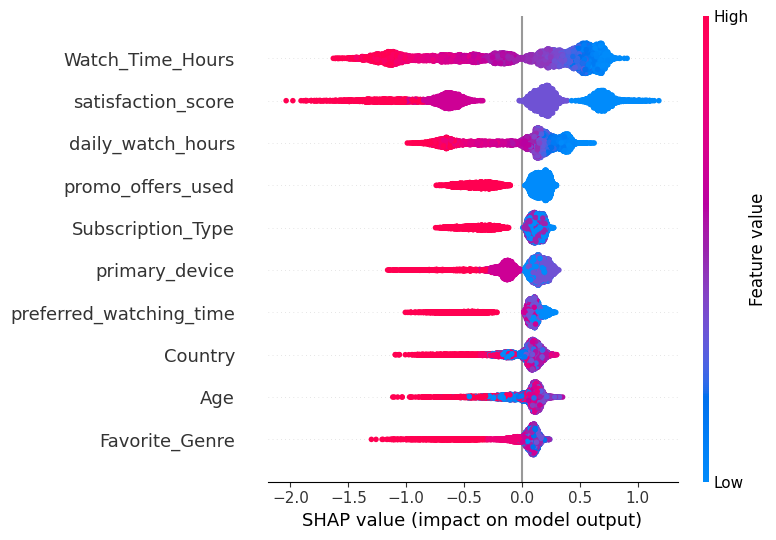

 모델 저장 완료: LightGBM_best_model.pkl

 모델 성능 요약 (정렬):

                Model                                        Best Params  \
0             XGBoost  {'colsample_bytree': 0.7, 'learning_rate': 0.1...   
1        RandomForest  {'max_depth': 10, 'max_features': 'sqrt', 'min...   
2            LightGBM  {'bagging_fraction': 0.8, 'bagging_freq': 5, '...   
3  LogisticRegression   {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}   

   Accuracy  F1 Score  
0  0.801055  0.803556  
1  0.792052  0.797089  
2  0.788837  0.791836  
3  0.766975  0.769583  
📁 성능 결과 저장 완료: results.csv


In [15]:
for item in models_and_params:
    name = item['name']
    print(f"\n GridSearch: {name}")

    grid = GridSearchCV(item['model'], item['params'], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1] if hasattr(best_model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n Classification Report for {name}:\n{report}")

    # ▶ Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(f"../result/{name} - Confusion Matrix.png")
    plt.show()

    # ▶ ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.tight_layout()
        plt.savefig(f"../result/{name} - ROC Curve.png")
        plt.show()

    # ▶ Feature Importance (트리 모델 전용)
    if hasattr(best_model, "feature_importances_"):
        importances = best_model.feature_importances_
        sorted_idx = np.argsort(importances)[::-1]
        plt.figure(figsize=(8, 6))
        plt.barh(np.array(feature_names)[sorted_idx][:10][::-1], importances[sorted_idx][:10][::-1])
        plt.title(f"{name} - Feature Importance (Top 10)")
        plt.tight_layout()
        plt.savefig(f"../result/{name} - Feature Importance (Top 10).png")
        plt.show()

    # ▶ SHAP 해석 (트리 기반 모델 전용)
    try:
        if name in ['XGBoost', 'LightGBM', 'RandomForest']:
            explainer = shap.Explainer(best_model, X_train)
            shap_values = explainer(X_test)
            shap.summary_plot(shap_values, X_test, feature_names=feature_names, max_display=10)
    except Exception as e:
        print(f"SHAP 해석 불가: {e}")

    # ▶ 모델 저장
    joblib.dump(best_model, f"{name}_best_model.pkl")
    print(f" 모델 저장 완료: {name}_best_model.pkl")

    # ▶ 결과 저장
    results.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Accuracy': acc,
        'F1 Score': f1
    })

# ▶ 결과 요약
df_results = pd.DataFrame(results).sort_values(by='F1 Score', ascending=False).reset_index(drop=True)
print("\n 모델 성능 요약 (정렬):\n")
print(df_results)

df_results.to_csv("model_results.csv", index=False)
print("📁 성능 결과 저장 완료: results.csv")


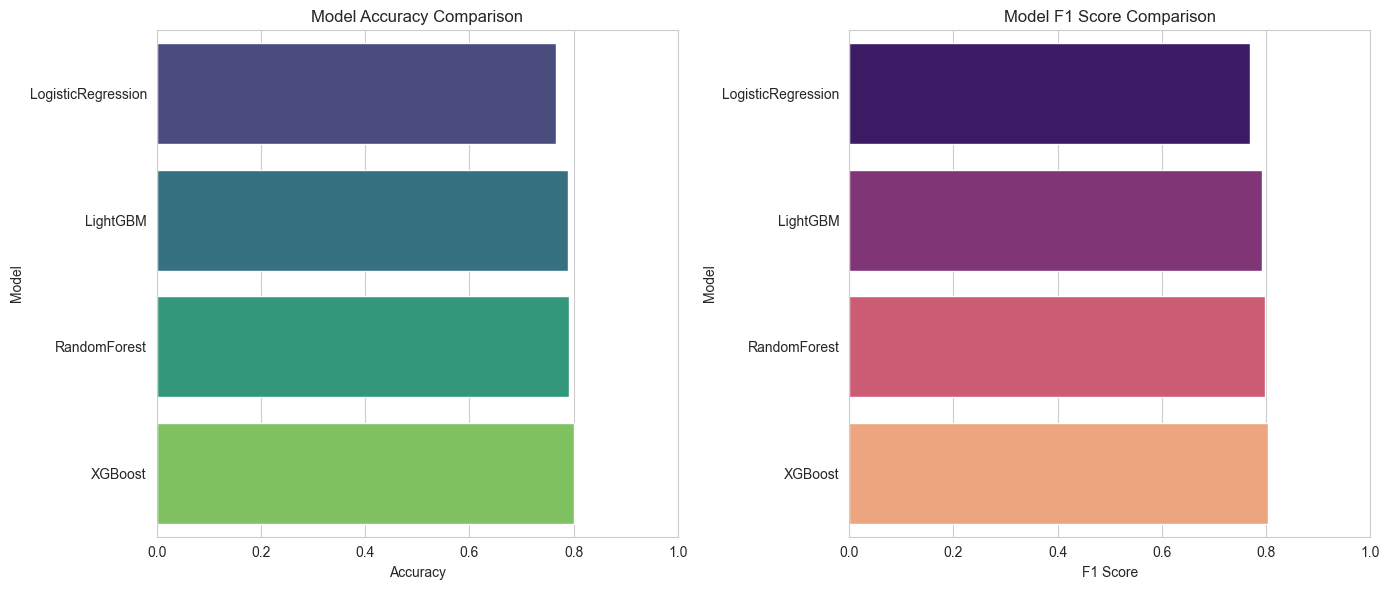

In [18]:
# ▶ 최종 모델 선택 및 저장
# data load 
df_results = pd.read_csv('./model_results.csv')
# Set plot style
sns.set_style(style="whitegrid")

# Create a figure with subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Barplot for Accuracy
sns.barplot(x='Accuracy', y='Model', data=df_results.sort_values('Accuracy', ascending=True), ax=axs[0], palette='viridis')
axs[0].set_title('Model Accuracy Comparison')
axs[0].set_xlim(0, 1)

# Barplot for F1 Score
sns.barplot(x='F1 Score', y='Model', data=df_results.sort_values('F1 Score', ascending=True), ax=axs[1], palette='magma')
axs[1].set_title('Model F1 Score Comparison')
axs[1].set_xlim(0, 1)

plt.tight_layout()
plt.show()


In [20]:
# 모델 불러오기 
model = joblib.load('./model/XGBoost_best_model.pkl')
model.predict(X_test)
# 컬럼과 인덱스 바꾸기 
a = pd.DataFrame([X_test.iloc[0]])
model.predict_proba(a)[:,1][0]

0.2859596

In [29]:
predict = model.predict(X_test)
(predict == y_test).sum() / len(y_test)


0.8010545267489712

array([3, 6, 1, 2, 5, 0, 4])